# Tutorial 2: Procesos de Markov

---
# Objetivos del Tutorial

En este tutorial, veremos los sistemas dinámicos introducidos en el primer tutorial desde una perspectiva diferente.

En el Tutorial 1, estudiamos los sistemas dinámicos como un proceso determinista. Para el Tutorial 2, veremos los sistemas dinámicos **probabilísticos**. A veces puedes escuchar que estos sistemas se llaman _estocásticos_. En un proceso probabilístico, se involucran elementos de aleatoriedad. Cada vez que observes algún sistema dinámico probabilístico, partiendo de las mismas condiciones iniciales, el resultado probablemente será diferente. Dicho de otra manera, los sistemas dinámicos que involucran probabilidad incorporarán variaciones aleatorias en su comportamiento.

Para algunos sistemas dinámicos probabilísticos, las ecuaciones diferenciales expresan una relación entre $\dot{x}$ y $x$ en cada momento $t$, de modo que la dirección de $x$ en _cada_ momento depende completamente del valor de $x$. Dicho de otra manera, el conocimiento del valor de las variables de estado $x$ en el tiempo t es _toda_ la información necesaria para determinar $\dot{x}$ y por lo tanto $x$ en el siguiente momento.

Esta propiedad — que el estado presente determina completamente la transición al siguiente estado — es lo que define un **proceso de Markov** y los sistemas que obedecen esta propiedad pueden describirse como **Markovianos**.

El objetivo del Tutorial 2 es considerar este tipo de proceso de Markov en un ejemplo simple donde las transiciones de estado son probabilísticas. En particular, vamos a:

* Entender los procesos de Markov y la dependencia de la historia.
* Explorar el comportamiento de un proceso telegráfico de dos estados y entender cómo su distribución de equilibrio depende de sus parámetros.

---
# Configuración

In [1]:
# @title Instalar e importar gadget de retroalimentación

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # Sin indicación de texto
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W2D2_T2"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.9 MB/s eta 0:00:00


In [2]:
# Importaciones
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Configuración de Figuras
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import ipywidgets as widgets  # visualización interactiva
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# @title Funciones de Trazado

def plot_switch_simulation(t, x):
  plt.figure()
  plt.plot(t, x)
  plt.title('Simulación de cambio de estado')
  plt.xlabel('Tiempo')
  plt.xlim((0, 300)) # acercar en el tiempo
  plt.ylabel('Estado del canal iónico 0/1', labelpad=-60)
  plt.yticks([0, 1], ['Cerrado (0)', 'Abierto (1)'])
  plt.show()


def plot_interswitch_interval_histogram(inter_switch_intervals):
  plt.figure()
  plt.hist(inter_switch_intervals)
  plt.title('Distribución de Intervalos entre Cambios')
  plt.ylabel('Conteo de Intervalos')
  plt.xlabel('tiempo')
  plt.show()


def plot_state_probabilities(time, states):
  plt.figure()
  plt.plot(time, states[:, 0], label='Cerrado')
  plt.plot(time, states[:, 1], label='Abierto')
  plt.xlabel('tiempo')
  plt.ylabel('prob(abrir O cerrar)')
  plt.legend()
  plt.show()

---
# Sección 1: Proceso Telegráfico

Este video cubre una definición de procesos de Markov y una introducción a la apertura/cierre de canales iónicos como ejemplo de un proceso telegráfico.

Consideremos un proceso de Markov con dos estados, donde los cambios entre cada dos estados son probabilísticos (conocido como un proceso telegráfico). Para ser concretos, digamos que estamos modelando un **canal iónico en una neurona que puede estar en uno de dos estados: Cerrado (0) o Abierto (1)**.

Si el canal iónico está Cerrado, puede hacer la transición al estado Abierto con probabilidad $P(0 \rightarrow 1 | x = 0) = \mu_{c2o}$. Del mismo modo, si el canal iónico está Abierto, hace la transición a Cerrado con probabilidad $P(1 \rightarrow 0 | x=1) = \mu_{o2c}$.

Simulamos el proceso de cambio de estados como un **proceso de Poisson**. Ya viste el proceso de Poisson en el [día de estadísticas de pre-requisitos](https://compneuro.neuromatch.io/tutorials/W0D5_Statistics/student/W0D5_Tutorial1.html). El proceso de Poisson es una forma de modelar eventos discretos donde se conoce el tiempo promedio entre ocurrencias de eventos, pero no se conoce el momento exacto de algún evento. Es importante destacar que el proceso de Poisson dicta los siguientes puntos:
1. La probabilidad de que ocurra algún evento es _independiente de todos los demás eventos_.
2. La tasa promedio de eventos dentro de un período de tiempo dado es constante.
3. Dos eventos no pueden ocurrir en el mismo momento. Nuestro canal iónico puede estar en un estado abierto o cerrado, pero no en ambos simultáneamente.

En la simulación a continuación, usaremos el proceso de Poisson para modelar el estado de nuestro canal iónico en todos los puntos $t$ dentro del tiempo total de simulación $T$.

A medida que simulamos el proceso de cambio de estado, también rast



Ejecuta la celda a continuación para mostrar el proceso de simulación de cambios de estado. Ten en cuenta que se estableció una semilla aleatoria en el bloque de código, por lo que volver a ejecutar el código producirá el mismo gráfico. Comentar esa línea producirá una simulación diferente en cada ejecución.

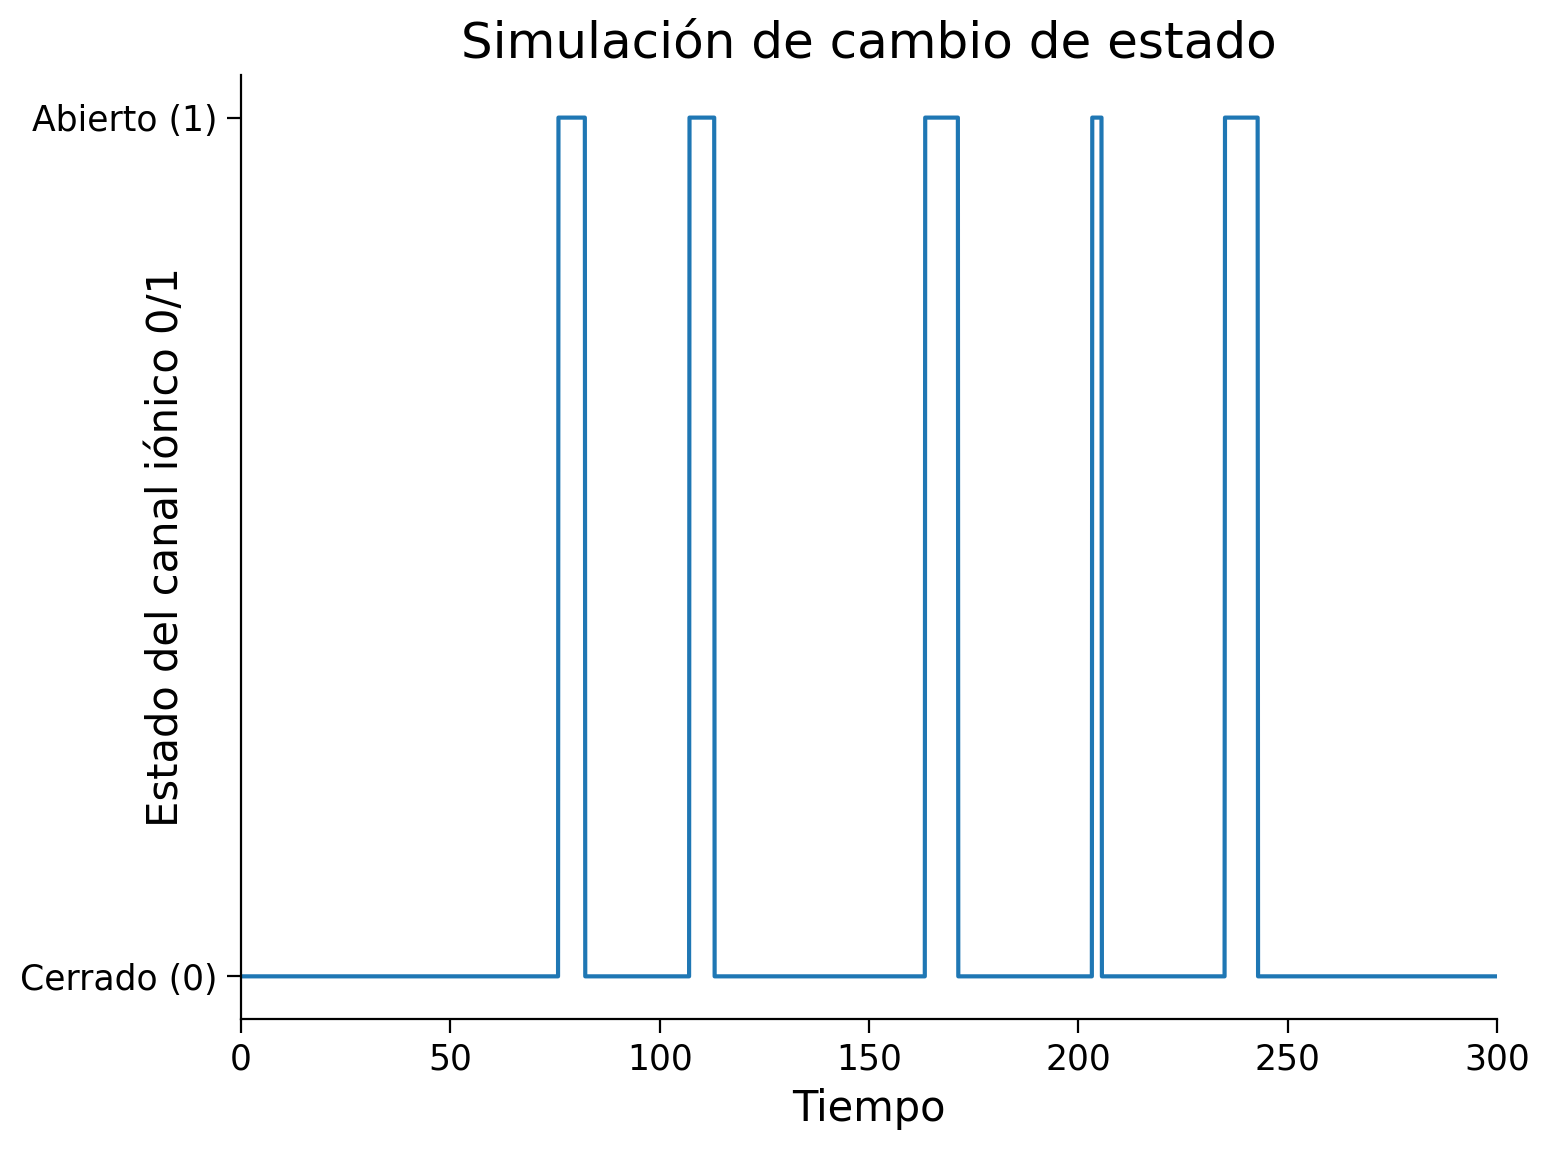

In [5]:
# @markdown Ejecuta para simular y representar los cambios de estado

# parámetros
T = 10000     # Duración total del tiempo
dt = 0.001   # Paso de tiempo de nuestra simulación

# Simular el estado de nuestro canal de iones en el tiempo
# Los dos parámetros que rigen las transiciones son
# c2o: tasa de cierre a abierto
# o2c: tasa de abierto a cierre
def ion_channel_opening(c2o, o2c, T, dt):
  # Inicializar variables
  t = np.arange(0, T, dt)
  x = np.zeros_like(t)
  switch_times = []

  # Suponemos que siempre comenzamos en estado Cerrado
  x[0] = 0

  # Generar una serie de números aleatorios uniformemente distribuidos
  # entre cero y uno: [0, 1),
  # uno para cada dt en nuestra simulación.
  # Utilizaremos estos números aleatorios para modelar las
  # transiciones de cerrado/abierto.
  myrand = np.random.random_sample(size=len(t))


  # Recorrer los pasos de tiempo de la simulación
  for k in range(len(t)-1):
    # Las transiciones entre estados de cerrado/abierto son
    # Procesos de Poisson
    if x[k] == 0 and myrand[k] < c2o*dt: # ¡recuerda escalar por dt!
      x[k+1:] = 1
      switch_times.append(k*dt)
    elif x[k] == 1 and myrand[k] < o2c*dt:
      x[k+1:] = 0
      switch_times.append(k*dt)

  return t, x, switch_times


c2o = 0.02
o2c = 0.1
np.random.seed(0) # establecer semilla aleatoria
t, x, switch_times = ion_channel_opening(c2o, o2c, T, .1)
plot_switch_simulation(t, x)

**Cálculo de intervalos entre cambios de estado**


Ahora tenemos la lista `switch_times`, que contiene los tiempos en los que se produjo un cambio de estado. Calcula los intervalos de tiempo entre cada cambio de estado y almacénalos en una lista llamada `inter_switch_intervals`.

Luego, graficaremos la distribución de estos intervalos. ¿Cómo describirías la forma de la distribución?


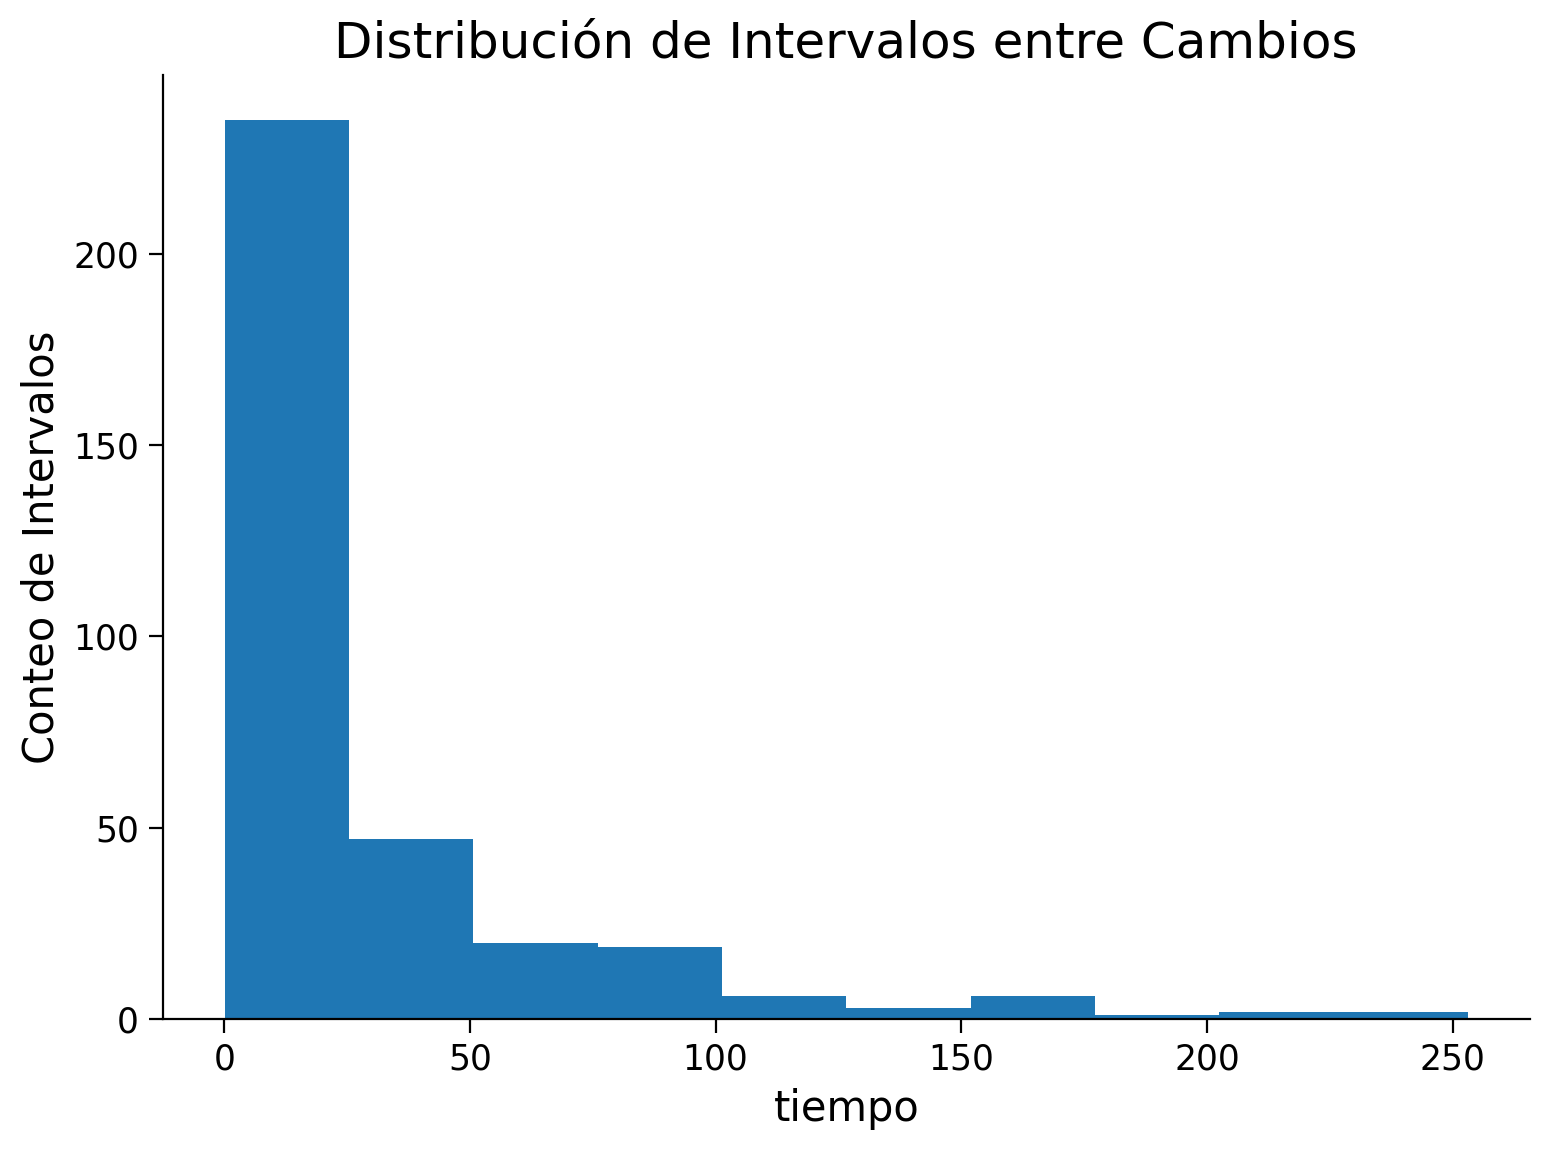

In [6]:
inter_switch_intervals = np.diff(switch_times)

# plot inter-switch intervals
plot_interswitch_interval_histogram(inter_switch_intervals)

En la siguiente celda, generamos un gráfico de barras para visualizar la distribución del número de pasos de tiempo transcurridos en cada uno de los dos posibles estados del sistema durante la simulación.


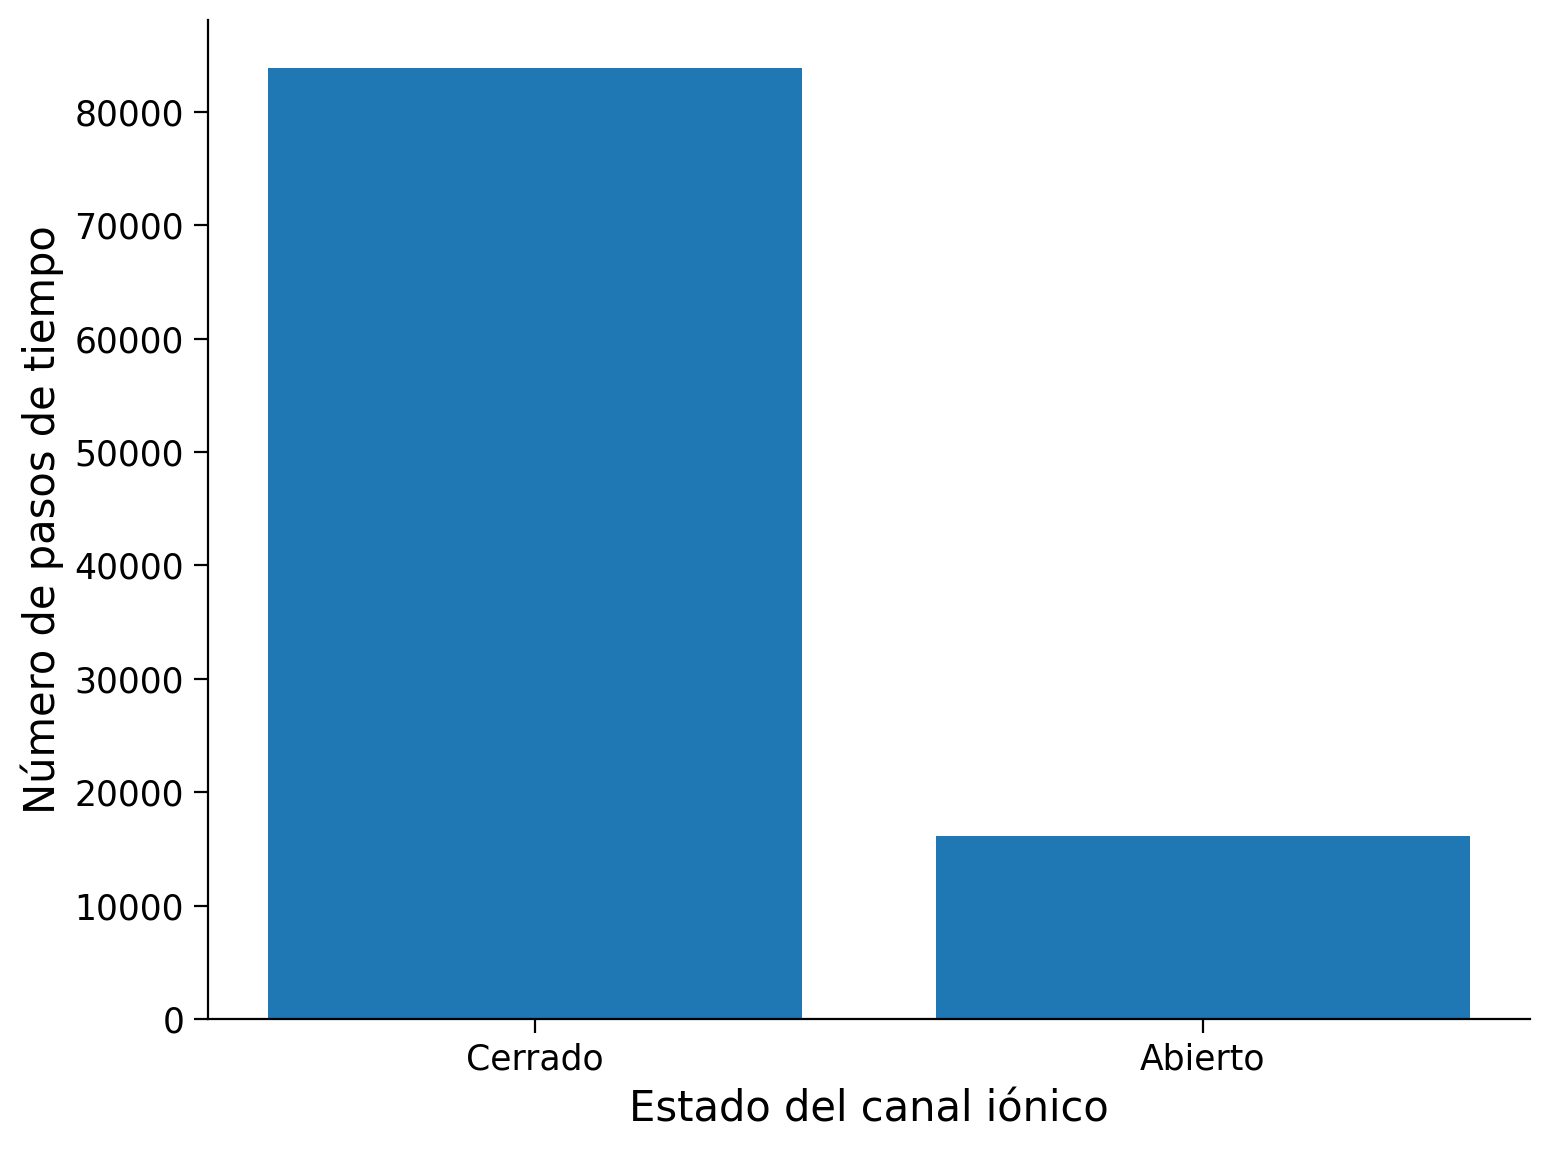

In [7]:
# @markdown Ejecute la celda para visualizar la distribución del tiempo transcurrido en cada estado.

states = ['Cerrado', 'Abierto']
(unique, counts) = np.unique(x, return_counts=True)

plt.figure()
plt.bar(states, counts)
plt.ylabel('Número de pasos de tiempo')
plt.xlabel('Estado del canal iónico')
plt.show()

<!-- Aunque el sistema comenzó inicialmente en el estado Cerrado ($x=0$), con el tiempo, se establece en una distribución de equilibrio donde podemos predecir en qué fracción de tiempo estará Abierto en función de $\mu $ parámetros.

Antes de continuar explorando estas distribuciones más a fondo, primero echemos un vistazo a esta fracción de estados abiertos como una media acumulativa del estado $x$: -->

Aunque el estado es _discreto_ (el canal iónico solo puede estar cerrado o abierto), aún podemos observar el **estado medio** del sistema, promediado durante un período de tiempo.

Dado que hemos codificado Cerrado como $x=0$ y Abierto como $x=1$, convenientemente, la media de $x$ durante una ventana de tiempo tiene la interpretación de **fracción de tiempo del canal abierto**.

También echemos un vistazo a la fracción de estados abiertos como media acumulativa del estado $x$. La media acumulada nos dice el número promedio de cambios de estado que habrá experimentado el sistema después de un cierto período de tiempo.

[]

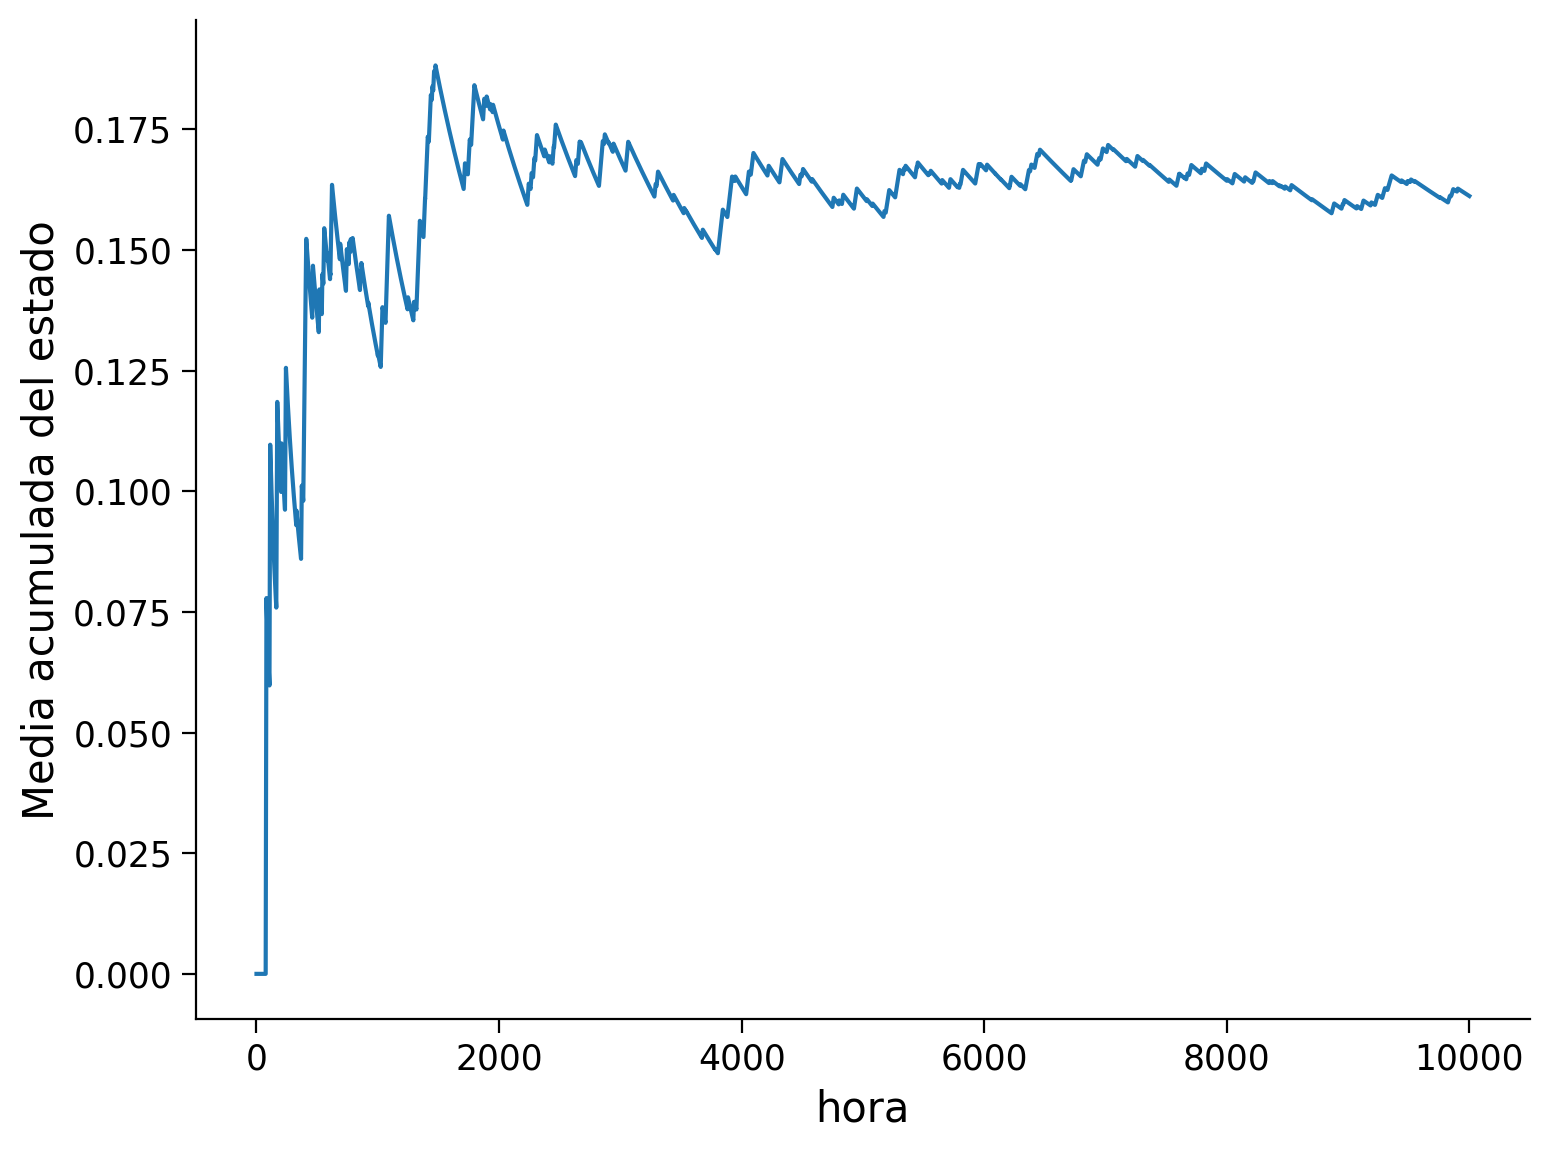

In [8]:
# @markdown Ejecutar para visualizar la media acumulada del estado
plt.figure()
plt.plot(t, np.cumsum(x) / np.arange(1, len(t)+1))
plt.xlabel('hora')
plt.ylabel('Media acumulada del estado')
plt.plot()

Observe en el gráfico anterior que, aunque el canal comenzó en el estado Cerrado ($x=0$), adoptó gradualmente algún valor medio después de un tiempo. Este valor medio está relacionado con las probabilidades de transición $\mu_{c2o}$
y $\mu_{o2c}$.

---
# Sección 2: Perspectiva Distribucional


Como tenemos MILLONES de canales, podemos pensar que en cada instante tenemos poblaciones enteras pasando por este proceso. Podemos modelar las poblaciones como sistemas dinámicos discretos!




\begin{equation}
\left[ \begin{array}{c} C \\ O \end{array} \right]_{k+1} = \mathbf{A} \left[ \begin{array}{c} C \\ O \end{array} \right]_k = \left[ \begin{array} & 1-p_{\text{c2o}} & p_{\text{o2c}} \\ p_{\text{c2o}} & 1-p_{\text{o2c}} \end{array} \right] \left[ \begin{array}{c} C \\ O \end{array} \right]_k
\end{equation}

Cada probabilidad de transición mostrada en la matriz es la siguiente:

$1-\mu_{\text{c2o}}$, la probabilidad de que el estado cerrado permanezca cerrado.
$\mu_{\text{c2o}}$, la probabilidad de que el estado cerrado haga una transición al estado abierto.
$\mu_{\text{o2c}}$, la probabilidad de que el estado abierto haga una transición al estado cerrado.
$1-\mu_{\text{o2c}}$, la probabilidad de que el estado abierto permanezca abierto.

</details>

_Observe_ que este sistema está escrito como un paso discreto en el tiempo, y $\mathbf{A}$ describe la transición, asignando el estado del paso $k$ al paso $k+1$. Esto es diferente de lo que hicimos en los ejercicios anteriores donde $\mathbf{A}$ había descrito la función desde el estado hasta la derivada temporal del estado.

## Ejercicio de codificación 2: propagación de probabilidad

*Referido en el video como ejercicio 2B*

Complete el siguiente código para simular la propagación de las probabilidades de cierre/apertura del canal iónico a través del tiempo. Se debe calcular una variable llamada `x_kp1` (abreviatura de $x$ en el paso de tiempo $k$ más 1) para cada paso *k* del bucle. Sin embargo, debes trazar $x$.

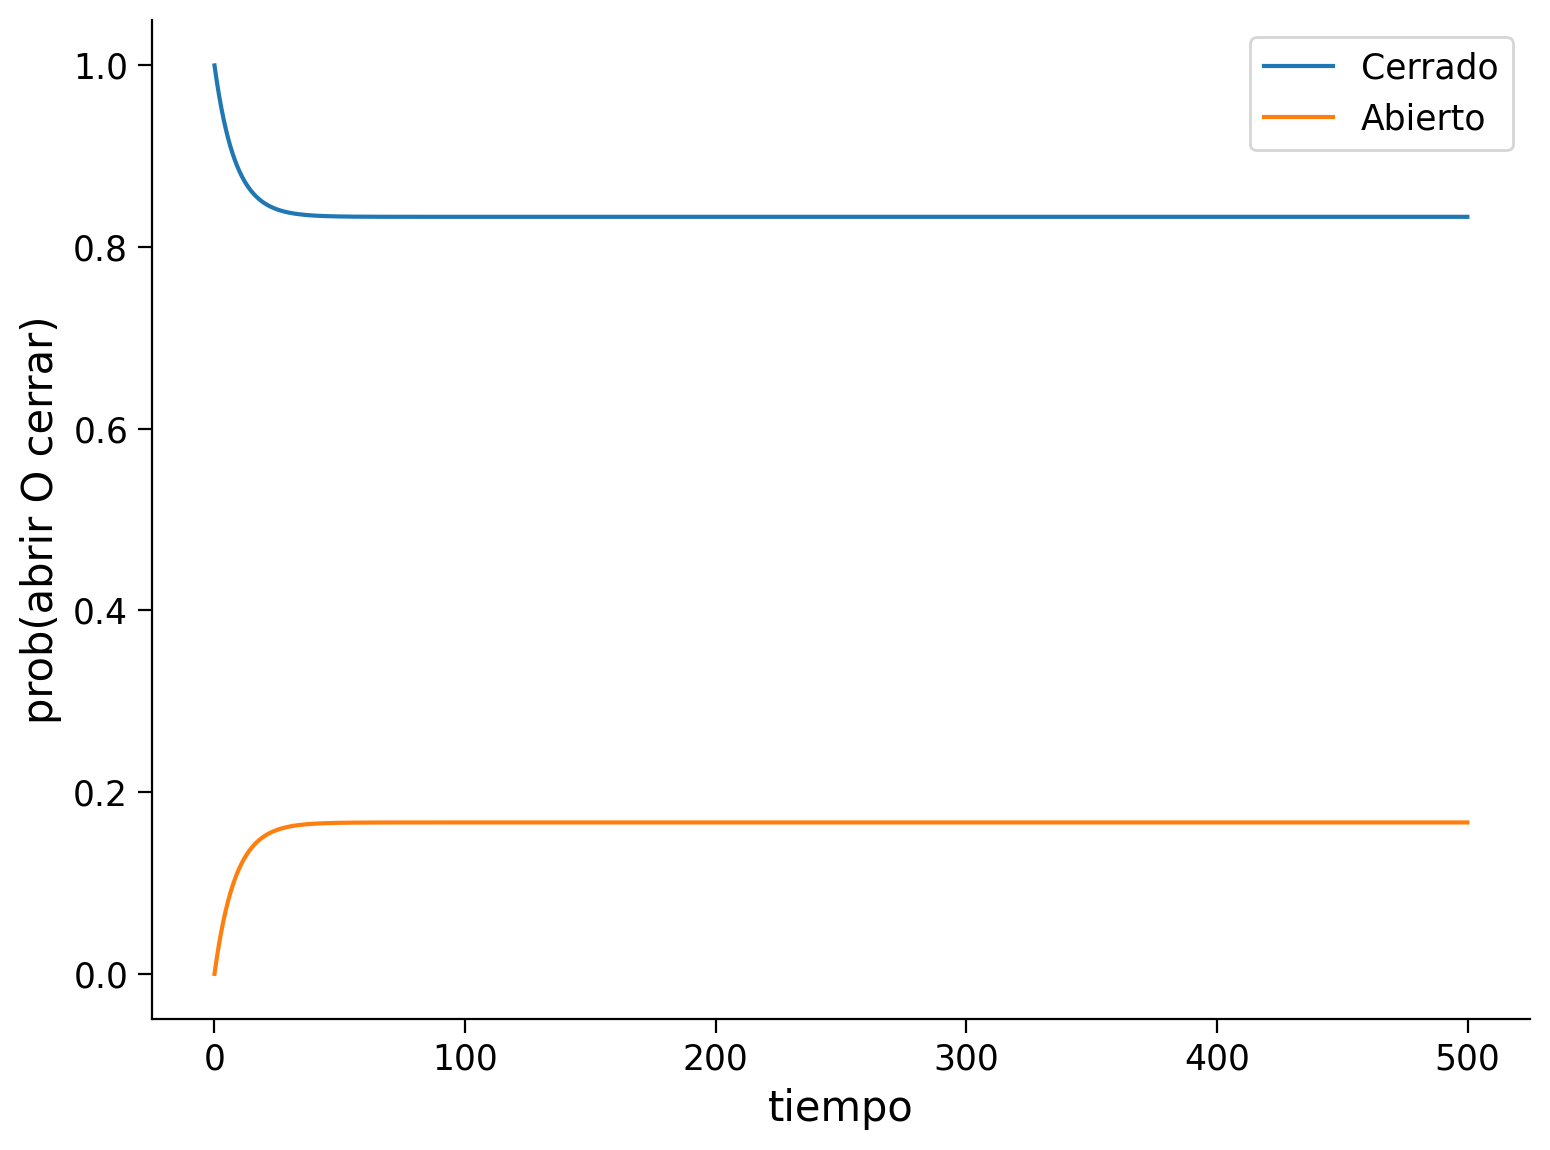

In [9]:

def simulate_prob_prop(A, x0, dt, T):
  """ Simulate the propagation of probabilities given the transition matrix A,
  with initial state x0, for a duration of T at timestep dt.

  Args:
    A (ndarray): state transition matrix
    x0 (ndarray): state probabilities at time 0
    dt (scalar): timestep of the simulation
    T (scalar): total duration of the simulation

  Returns:
    ndarray, ndarray: `x` for all simulation steps and the time `t` at each step
  """

  # Initialize variables
  t = np.arange(0, T, dt)
  x = x0 # x at time t_0

  # Step through the system in time
  for k in range(len(t)-1):
    # Compute the state of x at time k+1
    x_kp1 = np.dot(A, x[-1,:])

    # Stack (append) this new state onto x to keep track of x through time steps
    x = np.vstack((x, x_kp1))

  return x, t


# Set parameters
T = 500     # total Time duration
dt = 0.1   # timestep of our simulation

# same parameters as above
# c: closed rate
# o: open rate
c = 0.02
o = 0.1
A = np.array([[1 - c*dt, o*dt],
              [c*dt,     1 - o*dt]])

# Initial condition: start as Closed
x0 = np.array([[1, 0]])

# Simulate probabilities propagation
x, t = simulate_prob_prop(A, x0, dt, T)

# Visualize
plot_state_probabilities(t, x)

## Se acuerdan como calcular estos equilibrios?

Como se ve esto cuando llegamos al equilibrio?
\begin{equation}
\left[ \begin{array}{c} C \\ O \end{array} \right]_{k+1} = \mathbf{A} \left[ \begin{array}{c} C \\ O \end{array} \right]_k = \left[ \begin{array} & 1-p_{\text{c2o}} & p_{\text{o2c}} \\ p_{\text{c2o}} & 1-p_{\text{o2c}} \end{array} \right] \left[ \begin{array}{c} C \\ O \end{array} \right]_k
\end{equation}

#### Respuesta:
$x_k = Ax_k$

$(A-I)x_k = 0$

El estado estable es el autovector con autovalor 1 !

Nota: En general hay que normalizar $x_{estable}$ para que sume 1

Nota: pq conceptualmente tiene sentido que el autovalor sea 1?

---
# Sección 3: Equilibrio del proceso telegráfico

In [10]:
# calcular la descomposición propia de A
lam, v = np.linalg.eig(A)

# imprimir los 2 valores propios
print(f"Valores propios: {lam}")

# imprimir los 2 vectores propios
eigvec_1 = v[:, 0]
eigvec_2 = v[:, 1]
print(f"Vector propio 1: {eigvec_1} (normalizado = {eigvec_1/np.sum(eigvec_1)})")
print(f"Vector propio 2: {eigvec_2}")

Valores propios: [1.    0.988]
Vector propio 1: [0.98058068 0.19611614] (normalizado = [0.83333333 0.16666667])
Vector propio 2: [-0.70710678  0.70710678]
